<a href="https://colab.research.google.com/github/dhanya-krishnan-4502/VehicularSafety/blob/main/CAE_User_4_Train%26Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Libraries**


In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# **Load User 1 Dataset**

In [ ]:
data_user_1 = pd.read_excel('/content/drive/MyDrive/Bicycle_dataset/ID-4-modified.xlsx')
data_user_1 = data_user_1.dropna()

# **Visualising Feature vs Time**

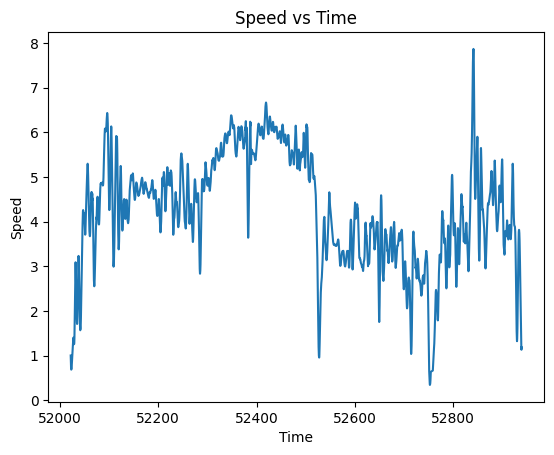

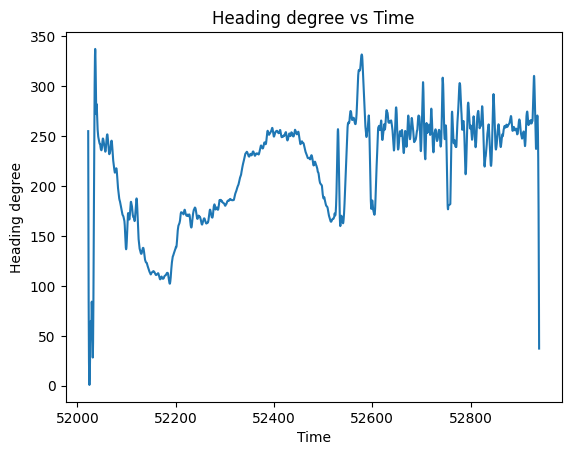

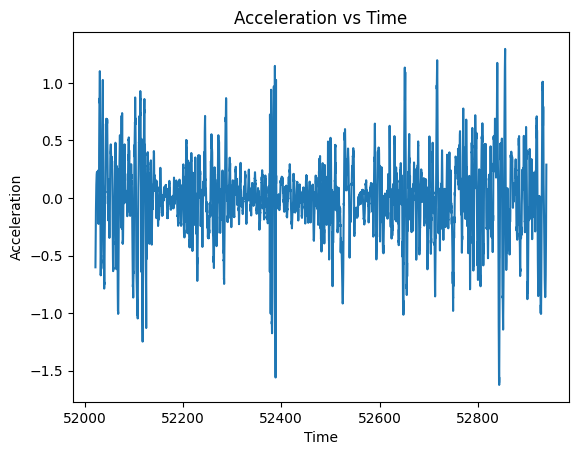

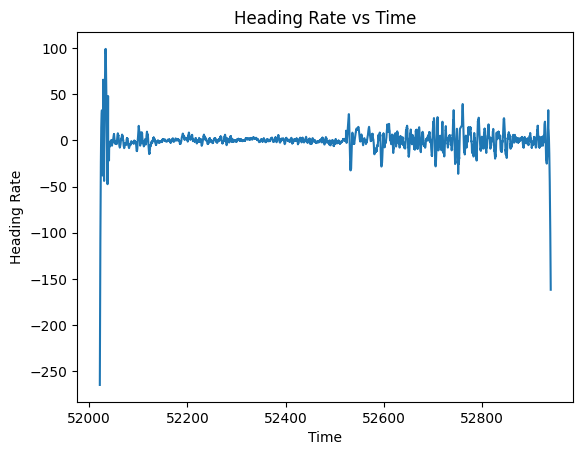

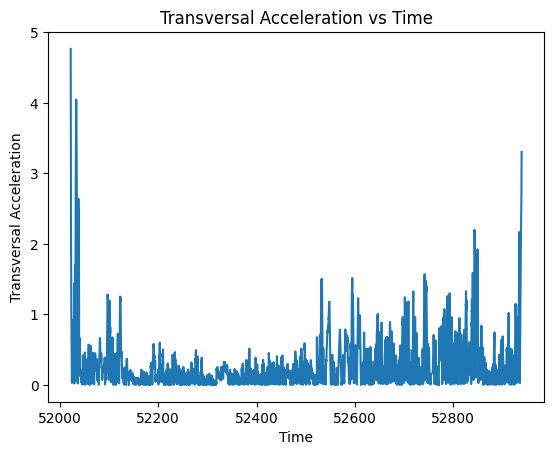

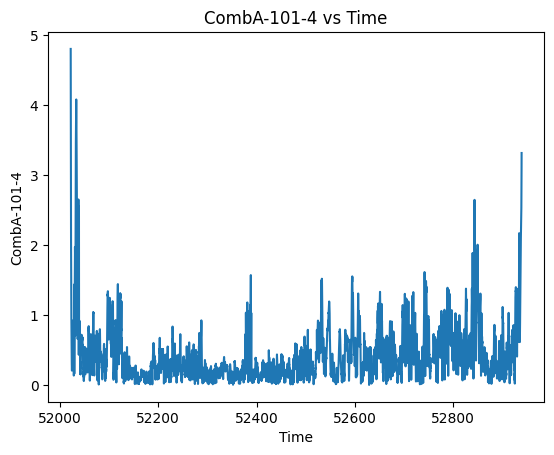

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

columns_to_plot = [ 'Speed', 'Heading degree', 'Acceleration', 'Heading Rate', 'Transversal Acceleration', 'CombA-101-4']

for column in columns_to_plot:
    plt.figure()
    plt.plot(data_user_1['Time'], data_user_1[column])
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.title(f'{column} vs Time')
    plt.show()

# **Splitting data into Test and Train**

In [ ]:
from sklearn.model_selection import train_test_split

features = data_user_1.drop(columns=['Rate'])
X_train, X_test = train_test_split(features, test_size=0.5, random_state=42)

# **Standardising Data**

In [ ]:
training_mean = X_train.mean()
training_std = X_train.std()
X_train_value = (X_train - training_mean) / training_std
print("Number of training samples:", len(X_train_value))

Number of training samples: 4569


# **Defining Time Sequence Creation function**

In [ ]:
TIME_STEPS = 50

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

x_train = create_sequences(X_train_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (4520, 50, 7)


# **Model Definition**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential(
    [
        layers.Input(shape=(50, 7)),
        layers.Conv1D(
            filters=32, kernel_size=3, padding="same", strides=1, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=3, padding="same", strides=1, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=3, padding="same", strides=1, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=3, padding="same", strides=1, activation="relu"
        ),
        layers.Conv1DTranspose(filters=7, kernel_size=3, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 32)            704       
                                                                 
 dropout (Dropout)           (None, 50, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 16)            1552      
                                                                 
 conv1d_transpose (Conv1DTr  (None, 50, 16)            784       
 anspose)                                                        
                                                                 
 dropout_1 (Dropout)         (None, 50, 16)            0         
                                                                 
 conv1d_transpose_1 (Conv1D  (None, 50, 32)            1568      
 Transpose)                                             

# **Training the Model**

In [ ]:
history = model.fit(
    x_train,
    x_train,
    epochs=40,
    batch_size=128,
    validation_split=0.1,
)

Epoch 1/40
32/32 [==============================] - 3s 46ms/step - loss: 0.9002 - val_loss: 0.6293
Epoch 2/40
32/32 [==============================] - 1s 22ms/step - loss: 0.5904 - val_loss: 0.3571
Epoch 3/40
32/32 [==============================] - 1s 22ms/step - loss: 0.4338 - val_loss: 0.2444
Epoch 4/40
32/32 [==============================] - 1s 20ms/step - loss: 0.3510 - val_loss: 0.1745
Epoch 5/40
32/32 [==============================] - 1s 21ms/step - loss: 0.3031 - val_loss: 0.1495
Epoch 6/40
32/32 [==============================] - 1s 21ms/step - loss: 0.2767 - val_loss: 0.1321
Epoch 7/40
32/32 [==============================] - 1s 21ms/step - loss: 0.2588 - val_loss: 0.1198
Epoch 8/40
32/32 [==============================] - 1s 21ms/step - loss: 0.2457 - val_loss: 0.1155
Epoch 9/40
32/32 [==============================] - 1s 21ms/step - loss: 0.2378 - val_loss: 0.1081
Epoch 10/40
32/32 [==============================] - 1s 21ms/step - loss: 0.2306 - val_loss: 0.0996
Epoch 11/

# **Plotting Training Loss**

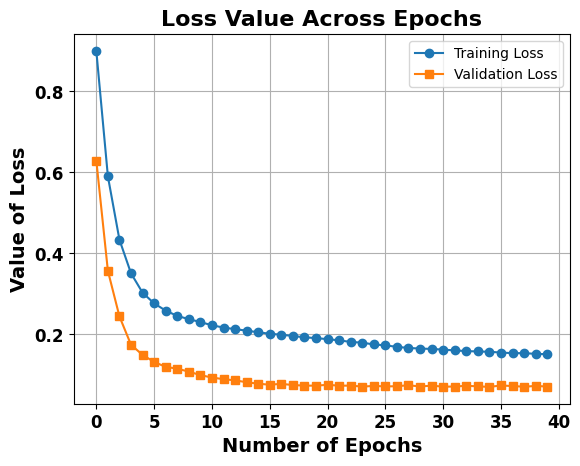

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss", marker='o')
plt.plot(history.history["val_loss"], label="Validation Loss", marker='s')

plt.xlabel('Number of Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Value of Loss', fontsize=14, fontweight='bold')
plt.title('Loss Value Across Epochs', fontsize=16, fontweight='bold')

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

plt.grid(True)  # Adding grid lines

plt.legend()
plt.show()


142/142 [==============================] - 1s 3ms/step


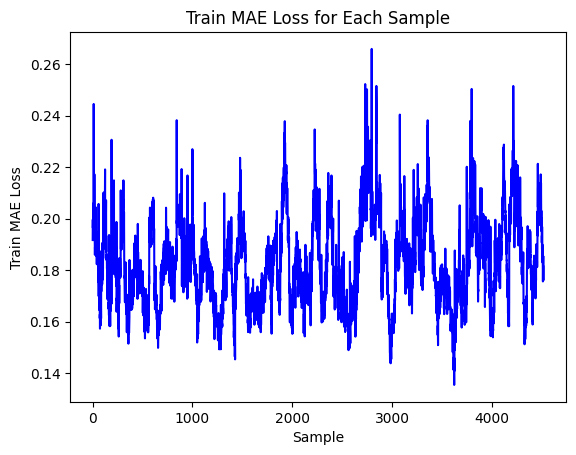

Reconstruction error threshold:  0.26589797156152034
Average Loss:  0.18217397017933903


In [ ]:
import matplotlib.pyplot as plt

x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=(1, 2))
plt.plot(range(len(train_mae_loss)), train_mae_loss, color='b')
plt.xlabel("Sample")
plt.ylabel("Train MAE Loss")
plt.title("Train MAE Loss for Each Sample")
plt.show()

threshold = np.max(train_mae_loss)
average_training_loss = np.mean(train_mae_loss)
print("Reconstruction error threshold: ", threshold)
print("Average Loss: ", average_training_loss)


# **Train vs Test loss on User 1(50:50 split)**

142/142 [==============================] - 0s 3ms/step


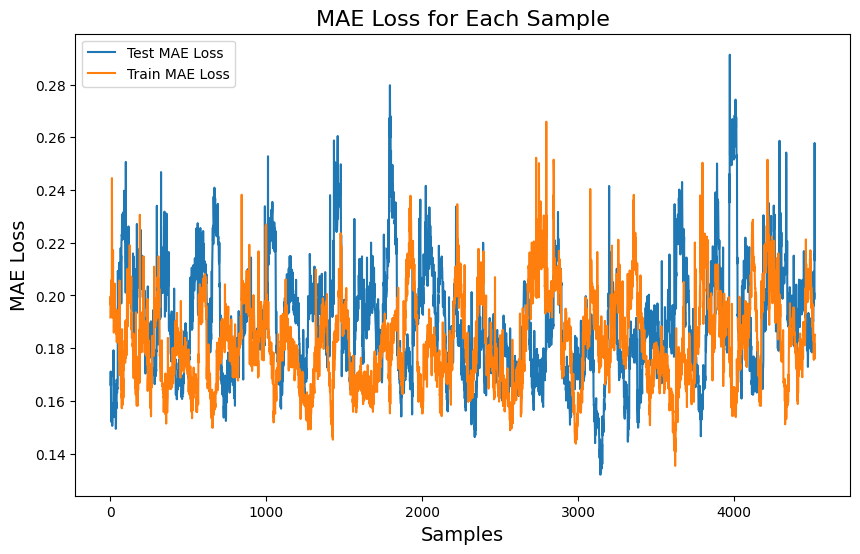

In [ ]:
import matplotlib.pyplot as plt

x_test = create_sequences((X_test - training_mean) / training_std)
x_train = create_sequences((X_train - training_mean) / training_std)

x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=(1, 2))

x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=(1, 2))

plt.figure(figsize=(10, 6))

plt.plot(range(len(test_mae_loss)), test_mae_loss, label='Test MAE Loss')
plt.plot(range(len(train_mae_loss)), train_mae_loss, label='Train MAE Loss')
plt.xlabel("Samples", fontsize=14)
plt.ylabel("MAE Loss", fontsize=14)
plt.title("MAE Loss for Each Sample", fontsize=16)
plt.legend()

plt.show()

142/142 [==============================] - 0s 3ms/step


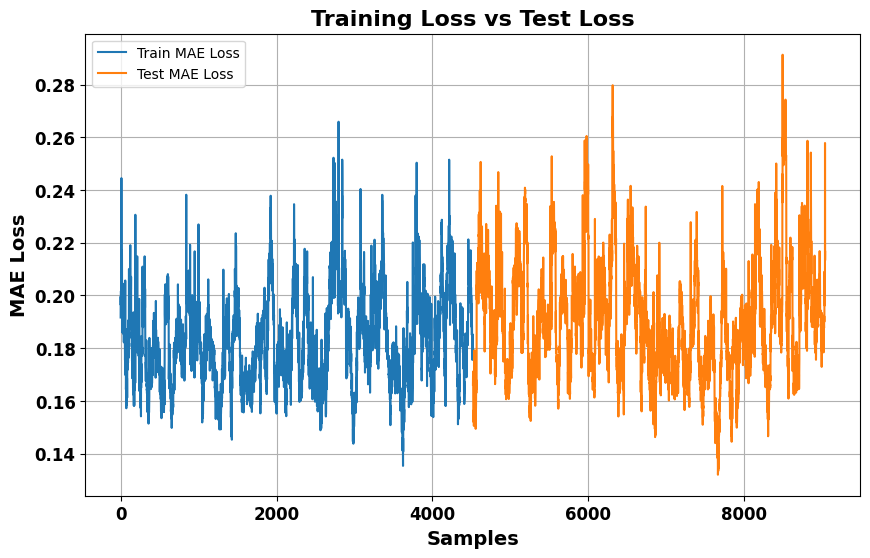

In [ ]:
import matplotlib.pyplot as plt

x_test = create_sequences((X_test - training_mean) / training_std)
x_train = create_sequences((X_train - training_mean) / training_std)

x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=(1, 2))

x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=(1, 2))

plt.figure(figsize=(10, 6))

plt.plot(range(len(x_train)), train_mae_loss, label='Train MAE Loss')

plt.plot(range(len(x_train), len(x_train) + len(test_mae_loss)), test_mae_loss, label='Test MAE Loss')

plt.xlabel("Samples", fontsize=14, fontweight='bold')
plt.ylabel("MAE Loss", fontsize=14, fontweight='bold')
plt.title("Training Loss vs Test Loss", fontsize=16, fontweight='bold')

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

plt.grid(True)

plt.legend()
plt.show()


In [ ]:
mean = np.mean(test_mae_loss)
sd = np.std(test_mae_loss)
print("Mean :", mean)
print("Standard Deviation :", sd)

Mean : 0.18946232532351
Standard Deviation : 0.021396070012608983


# **Test Losses on Users**

Test input shape (Graph 1 - Original User):  (4520, 50, 7)
142/142 [==============================] - 0s 3ms/step
Test input shape (User 1):  (4520, 50, 7)
142/142 [==============================] - 1s 5ms/step
Test input shape (User 2):  (4520, 50, 7)
142/142 [==============================] - 0s 3ms/step
Test input shape (User 3):  (4520, 50, 7)
142/142 [==============================] - 0s 3ms/step
Test input shape (User 5):  (4520, 50, 7)
142/142 [==============================] - 1s 4ms/step
Test input shape (User 6):  (4520, 50, 7)
142/142 [==============================] - 0s 3ms/step
Test input shape (User 7):  (4520, 50, 7)
142/142 [==============================] - 0s 3ms/step
Test input shape (User 8):  (4520, 50, 7)
142/142 [==============================] - 0s 3ms/step
Test input shape (User 9):  (4520, 50, 7)
142/142 [==============================] - 0s 3ms/step
Test input shape (User 10):  (4520, 50, 7)
142/142 [==============================] - 0s 3ms/step


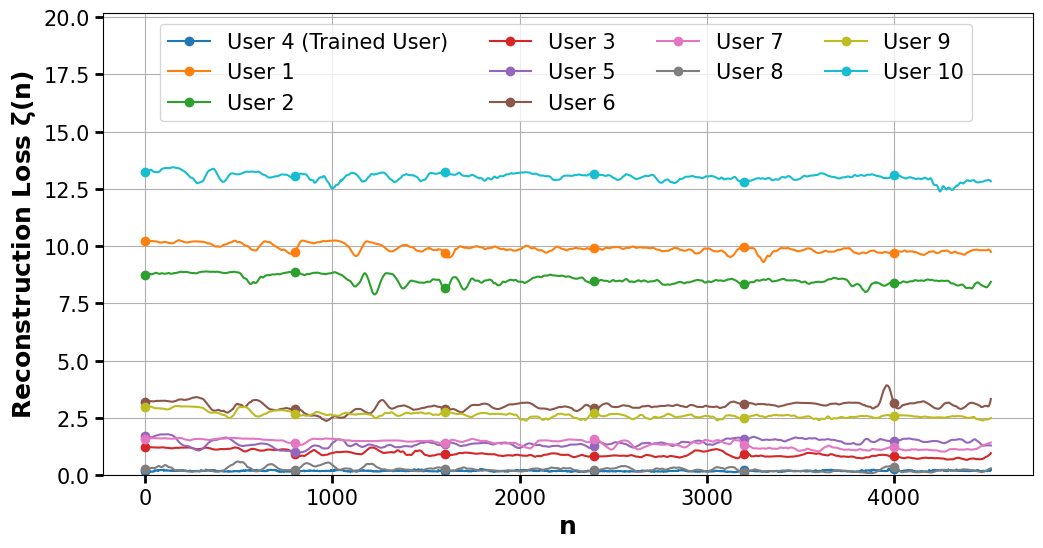

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


X_test_value_graph = (X_test - training_mean) / training_std
x_test_graph = create_sequences(X_test_value_graph.values)
average_test_loss = {}

print("Test input shape (Graph 1 - Original User): ", x_test_graph.shape)

x_test_pred_graph = model.predict(x_test_graph)

test_mae_loss_graph = np.mean(np.abs(x_test_pred_graph - x_test_graph), axis=(1, 2))
avg_loss = np.mean(test_mae_loss_graph)
average_test_loss[4] = avg_loss
num_samples = len(X_test)

user_ids_to_test = [1, 2, 3, 5, 6, 7, 8, 9, 10]

plt.figure(figsize=(12, 6))

plt.plot(range(num_samples-49), test_mae_loss_graph[-num_samples:], label='User 4 (Trained User)', marker='o', markevery=800)

max_loss = np.max(test_mae_loss_graph)

for user_id in user_ids_to_test:

    file_path = f'/content/drive/MyDrive/Bicycle_dataset/ID-{user_id}-modified.xlsx'
    data_user = pd.read_excel(file_path)
    data_user = data_user.dropna()

    User = data_user.drop(columns=['Rate'])

    X_test_value_user = (User - training_mean) / training_std

    num_samples_user = min(num_samples, len(X_test_value_user))
    x_test_user = create_sequences(X_test_value_user.values[-num_samples:])

    print(f"Test input shape (User {user_id}): ", x_test_user.shape)

    x_test_pred_user = model.predict(x_test_user)

    test_mae_loss_user = np.mean(np.abs(x_test_pred_user - x_test_user), axis=(1, 2))
    avg_loss = np.mean(test_mae_loss_user)
    average_test_loss[user_id] = avg_loss

    plt.plot(range(num_samples_user - num_samples, num_samples_user - 49), test_mae_loss_user, label=f'User {user_id}', marker='o', markevery=800)

    max_loss_user = np.max(test_mae_loss_user)
    if max_loss_user > max_loss:
        max_loss = max_loss_user


plt.xlabel("n", fontsize=18, fontweight='bold')
plt.ylabel(r"Reconstruction Loss $\mathbf{\zeta(n)}$", fontsize=18, fontweight='bold')
plt.legend(loc='upper left', bbox_to_anchor=(0.05, 1), fontsize=15, ncol=4)
plt.ylim(bottom=0, top=max_loss * 1.5)
plt.grid(True)

plt.gca().tick_params(axis='both', which='major', labelsize=15, width=2, length=6)
plt.gca().tick_params(axis='both', which='minor', labelsize=15, width=1, length=4)

plt.show()


In [ ]:
threshold = average_training_loss *2 #2 is threshold factor. we can adjust it depending on how sensitive we want the model to be
for user,loss in average_test_loss.items():
  if loss>threshold:
    print("User ",user)

User  1
User  2
User  3
User  5
User  6
User  7
User  9
User  10


In [ ]:
mean+sd

0.210858395336119

In [ ]:
average_test_loss

{4: 0.18946232532351,
 1: 9.899295857392906,
 2: 8.535153905815132,
 3: 0.9289838635194456,
 5: 1.4058859462476239,
 6: 3.0205884445220854,
 7: 1.3816611799592426,
 8: 0.25457179658952367,
 9: 2.632514862155841,
 10: 13.025796750283437}

In [ ]:
average_training_loss

0.18217397017933903

In [ ]:
average_test_loss[4]

0.18946232532351